### Connecting libraries and scripts

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/realestatepriceprediction/sample_submission.csv
/kaggle/input/realestatepriceprediction/train.csv
/kaggle/input/realestatepriceprediction/test.csv


In [47]:
import numpy as np
import pandas as pd
import random 
import sklearn as skl
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler , RobustScaler 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score as r2
from datetime import datetime
from sklearn.decomposition import PCA


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
matplotlib.rcParams.update({'font.size': 14})

In [50]:
def evaluate_preds(train_true_value, train_pred_value, test_true_value, test_pred_value):
    print("Train R2: \t" + str(round(r2(train_true_value, train_pred_value), 3)))
    print("Train R2: \t" + str(round(r2(test_true_value, test_pred_value), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_value, y=train_true_value)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_value, y=test_true_value)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Paths to directories and files

In [51]:
TEST_DATASET_PATH = '../input/realestatepriceprediction/test.csv'
TRAIN_DATASET_PATH = '../input/realestatepriceprediction/train.csv'

### Loading data 

### Описания полей датасета по недвижимости

#### Id - идентификационный номер квартиры,

#### DistrictId - идентификационный номер района,

#### Rooms - количество комнат,

#### Square - площадь,

#### LifeSquare - жилая площадь,

#### KitchenSquare - площадь кухни,

#### Floor - этаж,

#### HouseFloor - количество этажей в доме,

#### HouseYear - год постройки дома,

#### Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности,

#### Social_1, Social_2, Social_3 - социальные показатели местности,

#### Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья,

#### Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров,

#### Price - цена квартиры.


In [52]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [53]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [54]:
train_df.shape[1] - 1 == test_df.shape[1]

True

In [55]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Data overview

#### Target variable

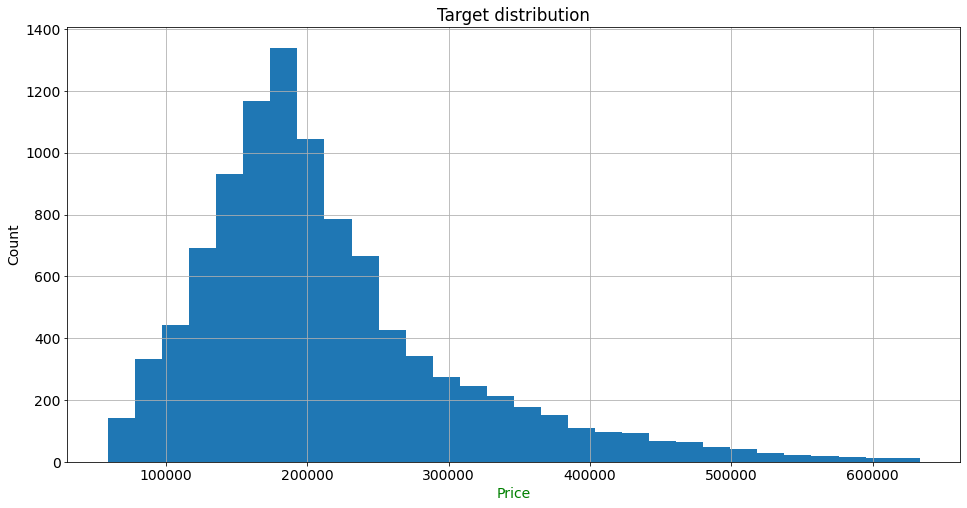

In [56]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins = 30)

plt.ylabel('Count')
plt.xlabel('Price', color = 'g')

plt.title('Target distribution')
plt.show()

In [57]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Data processing and generation of features

#### HouseFloor,Floor

In [58]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [59]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [60]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor']].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
26,8553,88,3.0,83.262530,4.769174,1.0,13,1.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.892020
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863
34,7757,27,2.0,58.783661,55.441256,11.0,13,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,138396.984612
37,1699,9,1.0,78.936164,76.746654,1.0,8,7.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,226206.962435
39,3736,167,2.0,56.712771,36.454064,7.0,6,5.0,1956,0.050272,B,B,21,4231,14,1020.0,0,3,B,299177.502635


In [61]:
train_df['HouseYear'].sort_values(ascending = False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [62]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

<Figure size 1440x576 with 0 Axes>

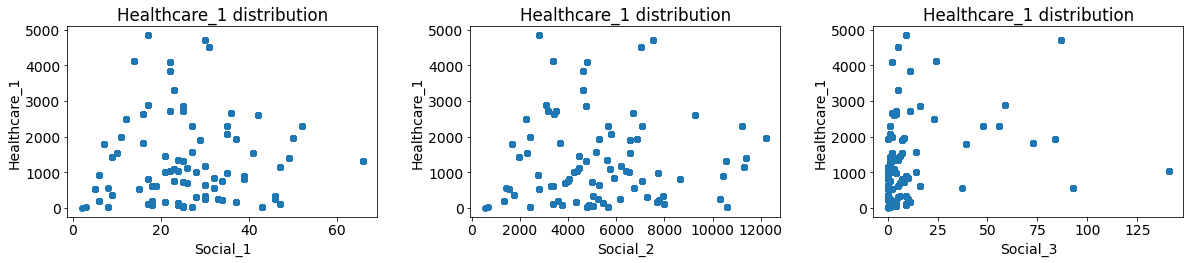

In [63]:
plt.figure(figsize = (20, 8))
fig, ax = plt.subplots(nrows = 1, ncols = 3)
ax1, ax2, ax3 = ax
ax1.scatter(train_df['Social_1'], train_df['Healthcare_1'])
ax1.set_xlabel('Social_1')
ax1.set_ylabel('Healthcare_1')
ax1.set_title('Healthcare_1 distribution')

ax2.scatter(train_df['Social_2'], train_df['Healthcare_1'])
ax2.set_xlabel('Social_2')
ax2.set_ylabel('Healthcare_1')
ax2.set_title('Healthcare_1 distribution')

ax3.scatter(train_df['Social_3'], train_df['Healthcare_1'])
ax3.set_xlabel('Social_3')
ax3.set_ylabel('Healthcare_1')
ax3.set_title('Healthcare_1 distribution')

fig.set_size_inches(20, 3.5)
plt.subplots_adjust(wspace = 0.3)
plt.show()

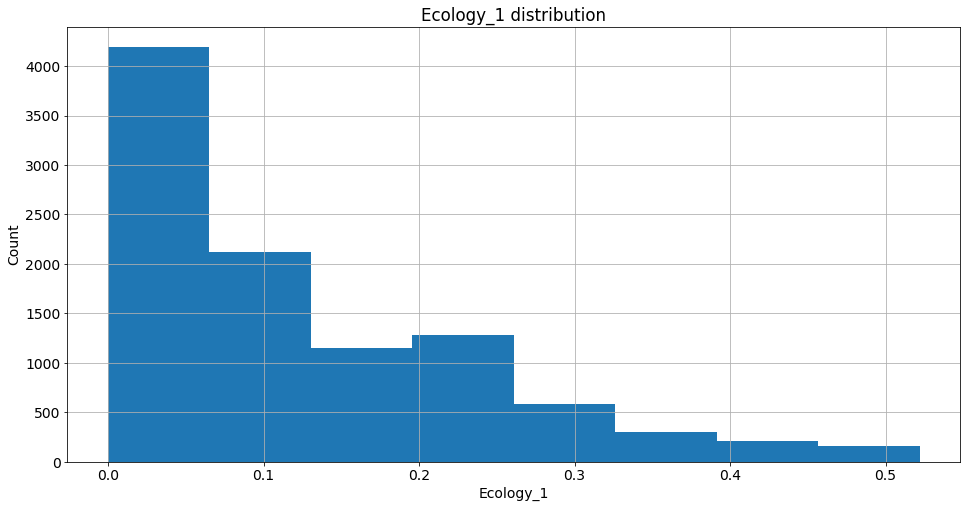

In [64]:
plt.figure(figsize = (16, 8))

train_df['Ecology_1'].hist(bins = 8)

plt.ylabel('Count')
plt.xlabel('Ecology_1')

plt.title('Ecology_1 distribution')
plt.show()

In [65]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [66]:
type('abc')

str

In [67]:
class DataPreprocessor:
    def __init__(self):
        self.medians = None 
        
        self.life_square_min_value = None 
        self.kitchen_min_value = None 
        self.kitchen_max_value  = None 
        self.medians = None 
        self.districts_healthcare = None
        self.house_floor_max = None
        
        
    def fit(self, df):    
        self.medians = df.median()
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.025) 
        self.kitchen_min_value = np.quantile(df['KitchenSquare'], q=0.3) 
        self.kitchen_max_value  = np.quantile(df['KitchenSquare'], q=0.999) 
        self.house_floor_max = 50
        
        # Compute mean Helthcare_1 value in each district
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        
    def transform(self, df):
        """data transformation"""
        
        # LifeSquare fillna
        
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare'])*0.9), inplace = True)
        
        
        #Rooms
        df['Rooms'].fillna(self.medians['Rooms'], inplace = True)
        condition_rooms = ( ( df['Rooms'] < 1 ) | ( df['Rooms'] > 5 ) | (df['Rooms'].isna()) ) 
        rooms_sq_mean = np.round((self.medians['LifeSquare'] / self.medians['Rooms'], 1))[0]
        df.loc[condition_rooms, 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / rooms_sq_mean
        
        #Square
        # If LifeSquare > Square: exchange values
        condition_sq = (train_df['Square']  < train_df['LifeSquare'])
        df.loc[condition_sq , 'Square'] =  (train_df.loc[condition_sq , 'LifeSquare'] + train_df.loc[condition_sq, 'KitchenSquare'])*1.1 
       
        # LifeSquare
        # Fill outliers with (Square - KithcenSquare)
        condition_lf = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[condition_lf, 'LifeSquare'] = df.loc[condition_lf, 'LifeSquare']
        
        
        #KitchenSquare
        condition_ks = ((df['KitchenSquare'] < self.kitchen_min_value) | (df['KitchenSquare'] > self.kitchen_min_value))
        df.loc[condition_ks, 'KitchenSquare'] = (df.loc[condition_ks, 'Square'] - df.loc[condition_ks, 'LifeSquare'])*0.9
        
        
        # Ecology and Shops
        # Switch to binary
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        # HouseFloorMax
        df.loc[df['HouseFloor'] > self.house_floor_max, 'HouseFloor'] = self.house_floor_max
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = 1
        df.loc[df['Floor'] == 0, 'Floor'] = 1
        
        # If HouseFloor < Floor: exchange values
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'Floor'] = df.loc[house_floor_condition, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # HouseYear
        # If HouseYear > current year set median value
        current_year = datetime.now().year
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians['HouseYear']
        
        #Replace the empty values Healthcare_1, with the average knowledge for the district
        
        df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians['Healthcare_1'] , inplace=True)
        
        q_max = np.quantile(df['Healthcare_1'], q = 0.9)
        df['Healthcare_1'].clip(upper = q_max, axis = 0, inplace = True)
        
        
        # Drop Id
        df.reset_index(drop=True, inplace=True)

        
        # Fillna just in case
        df.fillna(self.medians, inplace=True)
        return df

In [68]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
    
    def new_features(self, df):
        # How old is the district      
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Median square of flat in each district
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        floor_bins = [df['Floor'].min(), 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        
        
        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)
        
        
        
        
        
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        
        
        
        return df

### Machine Learning
#### Data preprocessing

In [69]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
test_df = preprocessor.transform(test_df)
train_df = preprocessor.transform(train_df)

#### Feature generation

In [70]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)

In [71]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Price,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
count,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.00000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000
mean,1.887848,56.436963,39.308447,13.337144,12.671515,1984.869495,0.118920,24.722727,5361.909798,8.03697,942.277825,4.238283,214098.561622,1978.275657,53.845050,3788.358685,1.101111,-0.000423
std,0.807103,18.038753,17.876727,10.067243,6.536042,18.388148,0.119152,17.532190,4008.008261,23.81571,725.111683,4.806456,92259.652438,9.276759,6.417134,1000.823538,1.271498,4.763447
min,1.000000,27.552992,0.370619,0.002649,1.000000,1910.000000,0.000000,0.000000,168.000000,0.00000,0.000000,0.000000,59174.778028,1924.500000,33.533077,2062.616352,-1.000000,-1.620569
25%,1.000000,42.140419,25.584184,1.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.00000,240.000000,1.000000,154250.429901,1975.000000,47.936648,2917.981612,0.000000,-1.606565
50%,2.000000,52.988610,35.912380,14.209069,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.00000,900.000000,3.000000,192356.666530,1977.000000,55.082103,3963.623529,1.000000,-1.210134
75%,2.000000,66.259448,48.471964,19.450333,17.000000,2001.000000,0.195781,36.000000,7287.000000,5.00000,1322.000000,6.000000,249100.769116,1980.000000,57.717659,4369.822512,2.000000,-0.612411
max,5.320342,135.847405,125.306808,95.685344,50.000000,2020.000000,0.521867,74.000000,19083.000000,141.00000,2300.000000,23.000000,633233.466570,2011.000000,85.591121,8361.390680,3.000000,26.592147


In [72]:
X = train_df.drop(columns = 'Price')
y = train_df['Price']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 4 )

In [74]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6633, 19), (3267, 19), (6633,), (3267,))

In [75]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.8679064038902078
0.7821926465002425


In [76]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

feature_importances

,feature_name,importance
3,Square,0.190735
16,DistrictPrice,0.166548
2,Rooms,0.157575
5,KitchenSquare,0.089322
4,LifeSquare,0.082058
10,Social_2,0.057927
9,Social_1,0.046491
18,Social,0.033421
7,HouseYear,0.027284
11,Social_3,0.026562


Train R2: 	0.868
Train R2: 	0.782


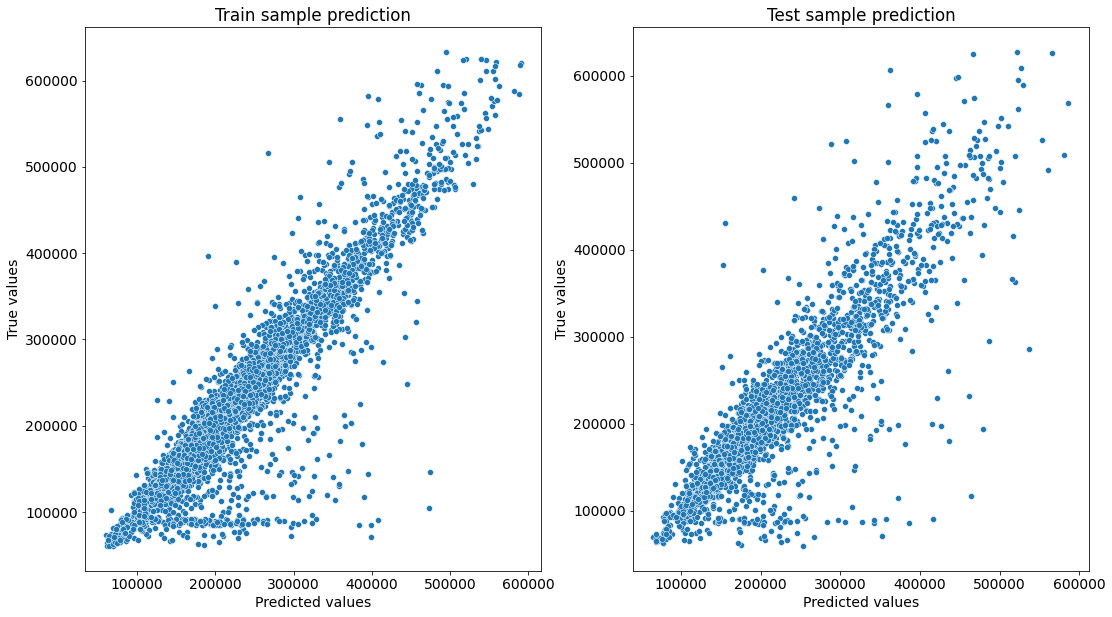

In [77]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [78]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 42))
cv_score


array([0.72975435, 0.76237122, 0.72984158])

In [79]:
test_df.isna().sum()

Id                 0
DistrictId         0
Rooms              0
Square             0
LifeSquare         0
KitchenSquare      0
HouseFloor         0
HouseYear          0
Ecology_1          0
Social_1           0
Social_2           0
Social_3           0
Healthcare_1       0
Shops_1            0
DistrictYear       0
DistrictDensity    0
DistrictPrice      0
Floor_cat          0
Social             0
dtype: int64

In [80]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
0,4567,44,1.0,36.847630,19.094182,15.978103,9.0,1970,0.036122,24,4378,0,905.979798,1,1977.0,47.650564,4368.562488,1.0,-1.654285
1,5925,62,1.0,42.493907,42.568133,-0.066803,17.0,2017,0.072158,2,629,1,900.000000,0,1977.0,57.717659,2807.932249,1.0,-1.462656
2,960,27,2.0,59.463678,45.417310,12.641731,19.0,1977,0.211401,9,1892,0,900.000000,1,1977.0,56.014915,2609.509171,3.0,-1.659865
3,3848,23,3.0,49.646030,33.893825,14.176984,2.0,1965,0.014073,2,475,0,0.000000,0,1977.0,55.167584,2062.616352,0.0,-1.662911
4,746,74,1.0,53.837056,47.553350,1.000000,17.0,1977,0.309479,35,7715,4,832.258065,6,1977.0,57.368986,3409.698779,2.0,-0.847631


In [81]:
submit = pd.read_csv('../input/realestatepriceprediction/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [82]:
predictions = gb_model.predict(test_df)
predictions

array([167637.88861976, 117994.08125717, 141308.40313783, ...,
       154557.31646888, 194580.52664815, 273465.23190967])

In [83]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,167637.888620
1,5925,117994.081257
2,960,141308.403138
3,3848,101431.682707
4,746,196968.205713


In [84]:
submit.to_csv('gb_submit.csv', index=False)